# Multi target regression from ROOT file
In this example we'll train a regressor to indirectly predict the $h\rightarrow\tau\bar{\tau}$ mass in non-resonant $hh\rightarrow b\bar{b}\tau\bar{\tau}$ events, by regressing to the 3-momenta of each $\tau$
1. Data is imported from ROOT format via Uproot (no need to install ROOT!)
1. Data is preprocessed
1. Initial feature selection is performed
1. Stochastic Weight Averaging is used to train a ReLU-based dense network using constant learning rate
1. The resulting model is evaluated on validation data
1. The model is interpreted via feature importance and partial dependencies

To get the data uncomment and run the cell below

In [1]:
# !mkdir data
# !wget -O data/root_data.tgz https://zenodo.org/record/3543638/files/root_data.tgz
# !tar -zxvf data/root_data.tgz -C data

If running in Google Collab, uncomment and run the cell below to install LUMIN

In [2]:
# !pip install lumin uproot
# !git clone https://github.com/SauceCat/PDPbox.git && cd PDPbox && pip install -e .

--> **RESTART INSTANCE TO ENSURE PDPBOX IS FOUND** <--

### Basic Modules

In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
from pathlib import Path
PATH = Path('./data')

## Data preparation

### Data import from ROOT file 
Use uproot to import the ROOT data into a pandas dataframe.
Example data is for the process $pp\rightarrow hh\rightarrow b\bar{b}\,\tau\bar{\tau}\rightarrow b\bar{b}\,\tau_h\mu$

In [5]:
import uproot
df = uproot.open(PATH/'signal.root')['tree'].pandas.df()

In [6]:
df.head()

,t_0_pT,t_0_eta,t_0_phi,t_0_mass,t_1_pT,t_1_eta,t_1_phi,t_1_mass,b_0_pT,b_0_eta,...,gen_h_bb_eta,gen_h_bb_phi,gen_h_bb_E,gen_h_tt_pT,gen_h_tt_eta,gen_h_tt_phi,gen_h_tt_E,gen_mctMatch,gen_weight,gen_target
entry,,,,,,,,,,,,,,,,,,,,,
0,36.850742,-1.301508,-0.449490,3.583080e+00,88.756241,-0.045828,0.801673,0.105658,101.773132,-0.621864,...,-0.366014,-2.261545,193.133926,167.054816,-0.364203,0.617325,217.716858,1.0,1.0,1.0
1,44.549965,1.641584,2.540022,1.228315e+00,68.820755,1.131779,-2.750534,0.105658,198.545624,1.155151,...,1.094840,-0.055264,477.111084,205.618939,1.476620,3.140846,489.813568,1.0,1.0,1.0
2,32.312160,0.225592,-2.485713,7.742898e-01,73.520073,0.495276,1.294261,0.105658,344.611084,0.085861,...,-0.034175,-0.278533,399.206879,66.369413,0.820306,1.702539,154.017578,1.0,1.0,1.0
3,55.896526,-1.680148,1.079537,4.889964e+00,32.492466,-1.598684,2.668608,0.105658,92.599792,-2.158637,...,-1.933018,-0.814522,517.224487,141.165349,-1.903520,2.270204,499.970337,1.0,1.0,1.0
4,47.391769,0.881903,2.025714,9.536743e-07,95.349663,0.173650,2.977873,0.105658,154.887131,0.073108,...,-0.028465,-0.835442,382.160492,253.092701,0.351680,2.796669,296.538849,1.0,1.0,1.0


Since only the $\mu+\tau_h$ decay channel is used, $t_1$ has a constant mass (muon mass), so we can simply drop it.

In [7]:
df.drop(columns=['t_1_mass'], inplace=True)

The data also contains events where the incorect final-states were chosen, since we need the reconstructed and generator-level objects to match for correct regression, we only want to train on the correctly selected events (gen_mctMatch == True)

In [8]:
df = df[df.gen_mctMatch == 1]; len(df)

61405

We can now check how poorly the reconstructed $h_{\tau\tau}$ mass matches to the true mass

In [9]:
df['gen_h_tt_delta'] = df['h_tt_mass']-125

`plot_feat` is a flexible function to provide indicative information about the 1D distribution of a feature. By default it will produce a weighted KDE+histogram for the [1,99] percentile of the data, as well as compute the mean and standard deviation of the data in this region. By passing a list of cuts and labels, it will plot multiple distributions of the same feature for different cuts. Since it is designed to provide quick, indicative information, more specific functions (such as `plot_kdes_from_bs`) should be used to provide final results.

/home/giles/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


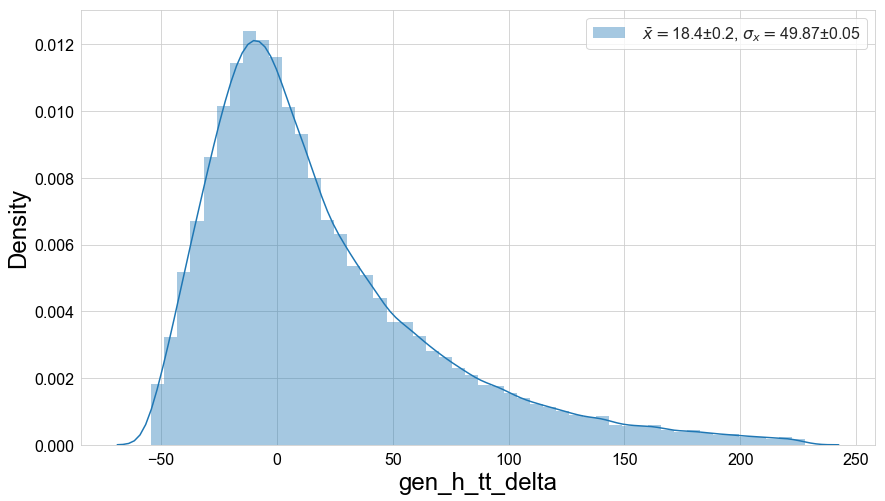

In [10]:
from lumin.plotting.data_viewing import plot_feat
plot_feat(df, 'gen_h_tt_delta')

The reconstruction of the $h_{\tau\tau}$ vector assumed that all of the missing  transverse momentum came from the decay, hence why there is a long tail out to over-estimations of the mass. Hopefully our regressor will be able to correct for this, however the Higgs mass is a constant value. We can't simply train the network to output 125 every time; it would not learn anything and would provide the same response to our background data as well.

Instead we can train it to output the 3-momenta of each of the taus the Higgs decays to. We can then calculate the invariant mass. **N.B.** even this approach is tricky as the regressor can easily learn to compute the Higgs mass, and use it to help regress to the tau momenta; again resulting in a peak when applied to background data, but this example is meant really meant to demonstrate how to use lumin.

### Preprocessing
Having imported the ROOT data, we now need to further process it into form suitable for training the regressor.

We can start by moving a Cartesian coordinate system; the HEP standard of $p_T,\ \eta,\ \phi$ can be a bit tricky, since $\phi$ is cyclical in nature, and $\eta$ is highly non-linear. Additionally, since the Higgs mass is invariant under transformations of the absolute orientation of each event, we can remove several symetries in the data by rotating each event to have the same orientation.

`proc_event` has options to set all events to have `ref_vec_0` at $\phi=0$ and be always in the positive $\eta$ region. The remaining symmetry of transverse reflection can be fixed by setting `ref_vec_1` to be in the positive $\phi$ region. The vectors can then transformed into Cartesian system via `use_cartesian` flag. The original vectors are automatically dropped, but can be kept if added to `keep_feat`. It can sometimes be useful to keep the absolute amount of $p_T^{\mathrm{miss}}$, since this is now non-linear combination of $p_x^{\mathrm{miss}}$ and $p_y^{\mathrm{miss}}$.

In [11]:
from lumin.data_processing.hep_proc import proc_event
proc_event(df, use_cartesian=True, fix_phi=True, fix_y=True, fix_z=True, ref_vec_0='t_0', ref_vec_1='t_1', keep_feats=['mPT_pT'])

Setting t_0 to phi = 0
Setting t_1 to positve phi
Setting t_0 to positive eta
eta component of mPT not found
Converting to use_cartesian coordinates


For quick access, we'll define here all the sets of features we'll later want use.

In [12]:
targ_feats = ['gen_t_0_px', 'gen_t_0_py', 'gen_t_0_pz', 'gen_t_1_px', 'gen_t_1_py', 'gen_t_1_pz']
gen_feats = [f for f in df.columns if 'gen_' in f]
cat_feats = [f for f in df.columns if f.startswith('n') if f != 'nPhotons']
cont_feats = [f for f in df.columns if f not in gen_feats+cat_feats]
print(len(cat_feats), cat_feats)
print(len(cont_feats), cont_feats)
train_feats = cont_feats + cat_feats

3 ['nJets', 'nBJets', 'nTauJets']
55 ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'hT', 'sT', 'centrality', 'eVis', 'minJetPT', 'meanJetPT', 'maxJetPT', 'minJetMass', 'meanJetMass', 'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'nPhotons', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA', 'dShapeA', 'sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 'upsilonP', 'dShapeP', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'mPT_px', 'mPT_py', 'diH_px', 'diH_py', 'diH_pz', 't_0_px', 't_0_pz', 'b_0_px', 'b_0_py', 'b_0_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 't_1_px', 't_1_py', 't_1_pz', 'mPT_pT']


Several of the categorical features display long tails, making it difficult to ensure decent population. We're perhaps more interest in whether events contain few, several, or lots of jets, rather that the exact number, so we'll simply cut to the tails and more the last category to be $x$ or greater.

In [13]:
df.loc[df.nJets >= 5, 'nJets'] = 4
df.loc[df.nBJets >= 5, 'nBJets'] = 4
for f in cat_feats:
    s = set(df[f])
    print(f, len(s), s)

nJets 2 {3.0, 4.0}
nBJets 3 {2.0, 3.0, 4.0}
nTauJets 3 {1.0, 2.0, 3.0}


To create our validation set, we'll eventually pull out a random sample, however it can be useful to ensure as much similarity as possible by doing a stratified split using the categories in the data. `ids2unique` maps each set of categories to a unique integer, allowing us to create a single set of values to use as the stratification key.

In [14]:
from lumin.utils.misc import ids2unique
df['gen_strat_key'] = ids2unique(df[cat_feats].values)

In [15]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
df.columns[df.isna().any()].tolist()

[]

#### Train-validation split 

In [17]:
from sklearn.model_selection import train_test_split 
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.gen_strat_key, random_state=1111)

Having pulled out a stratified random subsample, we can check whether it really is representative of the train data (and our test set if we had one) by seeing whether we can use the input features to identify which dataset each event belongs to. If there our some features which allow the sets to be identified, then we could remove them from the inputs to improve the generalisation of the model.

`check_val_set` runs some random forests to try and predict the originating datasets of the events, and then returns the area under the ROC curve for the classifiers. Ideally this should be 0.5, indicating it can only do as well as random guessing. Training and inference use weights to account for the fact that the datasets may have uneven populations.

In [18]:
from lumin.utils.data import check_val_set
check_val_set(train_df, val_df)

/home/giles/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)



AUC for train-validation discrimination = 0.5003222678714316
Top 10 most important features are:
   index      Feature  Importance
0      0  sphericityP    0.008015
1      1  aplanorityP    0.006137
2      2      dShapeP    0.005260
3      3       t_0_pz    0.005009
4      4    h_tt_mass    0.004884
5      5       b_0_py    0.004884
6      6       b_0_pz    0.004759
7      7   maxJetMass    0.004508
8      8     upsilonP    0.003882
9      9       t_0_px    0.003757


#### Final preprocessing
The network weights will use initialisation schemes which expect the inputs to be unit Gaussian. We'll use sklearn pipelines to package transformations which alter the data to have mean zero and standard deviation one.

In [19]:
from lumin.data_processing.pre_proc import fit_input_pipe
input_pipe = fit_input_pipe(train_df, cont_feats, PATH/'input_pipe')

In [20]:
train_df[cont_feats] = input_pipe.transform(train_df[cont_feats])
val_df[cont_feats] = input_pipe.transform(val_df[cont_feats])

Since we'll be using entity embeddings for the categorical features, we want to transform their codes to start from zero and increase incrementaly. We also need to make sure the validation (and test) sets receive the same transformaitions as the training set.

`proc_cats` does this and returns dictionaries of the both the mapping that was applied, and the cardinality of each feature.

In [21]:
from lumin.data_processing.pre_proc import proc_cats
cat_maps, cat_szs = proc_cats(train_df, cat_feats, val_df)
cat_maps, cat_szs

(OrderedDict([('nJets', {0: 3.0, 1: 4.0}),
              ('nBJets', {0: 2.0, 1: 3.0, 2: 4.0}),
              ('nTauJets', {0: 1.0, 1: 2.0, 2: 3.0})]),
 OrderedDict([('nJets', 2), ('nBJets', 3), ('nTauJets', 3)]))

### Conversion to fold file 

Having finished processing the data, we can now save it to h5py files in a format that `FoldYielder` will expect.

In [22]:
from lumin.data_processing.file_proc import df2foldfile
df2foldfile(df=train_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=targ_feats,
            savename=PATH/'train', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 4913 events
Saving fold 1 with 4913 events
Saving fold 2 with 4913 events
Saving fold 3 with 4913 events
Saving fold 4 with 4912 events
Saving fold 5 with 4912 events
Saving fold 6 with 4912 events
Saving fold 7 with 4912 events
Saving fold 8 with 4912 events
Saving fold 9 with 4912 events


In [23]:
df2foldfile(df=val_df, n_folds=10,
            cont_feats=cont_feats, cat_feats=cat_feats, cat_maps=cat_maps, targ_feats=targ_feats,
            savename=PATH/'val', targ_type='float32', strat_key='gen_strat_key')

Saving fold 0 with 1229 events
Saving fold 1 with 1228 events
Saving fold 2 with 1228 events
Saving fold 3 with 1228 events
Saving fold 4 with 1228 events
Saving fold 5 with 1228 events
Saving fold 6 with 1228 events
Saving fold 7 with 1228 events
Saving fold 8 with 1228 events
Saving fold 9 with 1228 events


## Feature selection

Currently we're using all of the available information from the ROOT file, however it contains an awful lot of high-level features which may not be useful for the regression. We can run a few checks to try and filter out the uneeded features. For a more in depth look into feature selection check out the `Feature_Selection.ipynb` example.

`FoldYielder` is the base class we'll use to pull data from the h5py file. We can also recover the original dataframe via `get_df`, and de-process it by adding the input pipe.

In [24]:
from lumin.nn.data.fold_yielder import FoldYielder
train_fy = FoldYielder(h5py.File(PATH/'train.hdf5', "r+"), input_pipe=input_pipe)
train_df = train_fy.get_df(inc_inputs=True, deprocess=True, nan_to_num=True); train_df.head()

49124 datapoints loaded


,t_0_mass,b_0_mass,b_1_mass,h_tt_mass,h_bb_mass,diH_mass,hT,sT,centrality,eVis,...,mPT_pT,nJets,nBJets,nTauJets,gen_target_0,gen_target_1,gen_target_2,gen_target_3,gen_target_4,gen_target_5
0,6.977679e-07,19.486555,9.993212,117.448898,119.478081,510.779816,273.798401,471.566620,0.830972,464.856354,...,83.119995,0.0,0.0,0.0,70.099480,-1.355148,6.452147,94.448181,146.020233,123.672958
1,9.565388e+00,25.858034,15.887206,213.809265,128.570923,775.260071,457.714966,725.210144,0.776821,648.351990,...,218.619308,0.0,0.0,0.0,91.654999,0.064574,125.277679,234.769485,172.758972,213.617783
2,6.256784e+00,12.837456,11.155560,241.383255,123.984039,545.982056,492.927032,663.888855,0.120928,4858.093750,...,73.647926,1.0,0.0,0.0,135.633499,1.238244,380.092163,63.520046,94.882126,214.404221
3,5.253722e+00,9.942270,6.921564,208.570053,103.883675,396.591827,228.501450,274.908722,0.352109,703.230103,...,25.964874,0.0,0.0,0.0,116.827805,3.662287,574.407410,-28.428989,0.410180,59.554356
4,1.977851e+00,10.783857,13.787074,133.610291,121.364464,423.064941,293.559113,419.625946,0.299340,1046.386230,...,104.215469,1.0,0.0,0.0,89.574158,-2.011332,74.094337,48.409111,58.276779,254.724838


We'll also want to split off another, temporary validation set

In [25]:
df_trn, df_val = train_test_split(train_df, test_size=0.2)

We're mainly interested in filtering down the high-level features, and will assume that the random forests we'll be using will not be able to make as much use of the lower level information as the neural networks will, so we'll only test the high level features and add regularisation as necessary later.

In [26]:
vec_feats = []
for c in ['px', 'py', 'pz', 'mass']:
    vec_feats += [f for f in train_feats if f == f'{f[:f.rfind("_")+1]}{c}']
len(vec_feats)

28

In [27]:
hl_feats = [f for f in train_feats if f not in vec_feats]; len(hl_feats)

30

Let's see which of the high-level features the RFs find useful. `rf_rank_features` wraps rfpimp and initially trains a RF using the data and eveluates it on the validation set. It then sequentially makes a copy of the data and randomises the order of one of the fetaures and then reevaluates the model performance, and compares it to the original score. If their is a large decrease in the score, then the feature which was randomised was very important in the model. If there is only a small decrease (or increase) in the score, then the feature was not important. If there is only a small decrease (or increase) in the score, then the feature was not important. 

Having established the importance of the features, `rf_rank_features` then runs another training only using the features with importances higher the the `cut` argument. If there is no decrease in the score, the ignored features can probably be safely removed.

Optimising RF parameters


Evalualting importances


Top ten most important features:
        Feature  Importance
0       mPT_pT    0.396863
1           sT    0.302041
2   centrality    0.278478
3    meanJetPT    0.264329
4    minJetEta    0.242093
5           hT    0.185552
6  aplanorityP    0.170161
7    maxJetEta    0.142335
8         eVis    0.121492
9  spherocityP    0.108229


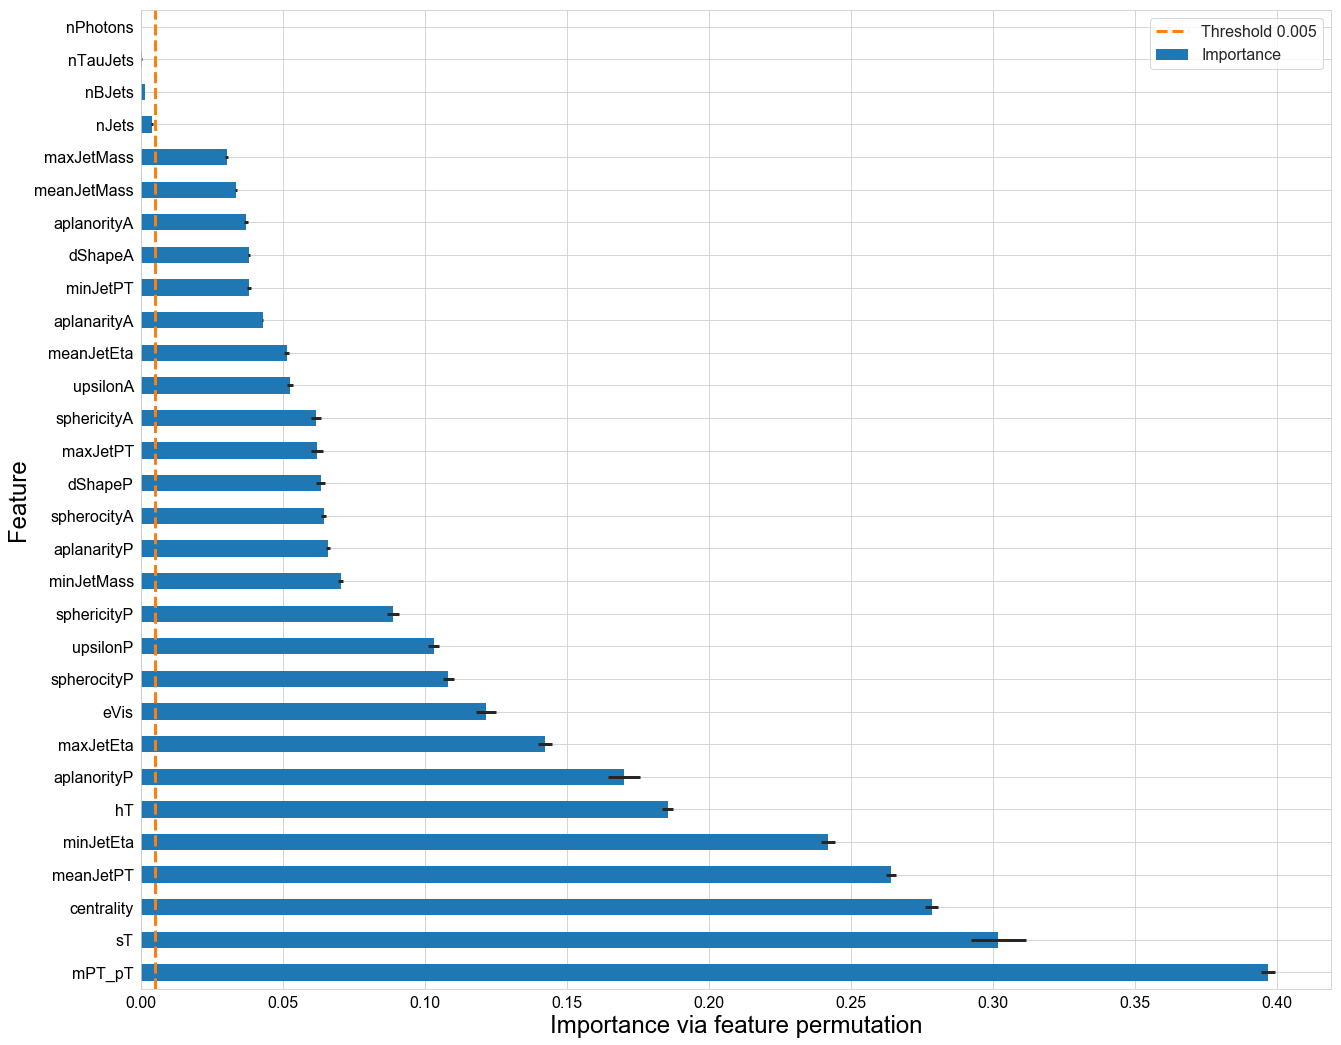


26 features found with importance greater than 0.005:
 ['mPT_pT', 'sT', 'centrality', 'meanJetPT', 'minJetEta', 'hT', 'aplanorityP', 'maxJetEta', 'eVis', 'spherocityP', 'upsilonP', 'sphericityP', 'minJetMass', 'aplanarityP', 'spherocityA', 'dShapeP', 'maxJetPT', 'sphericityA', 'upsilonA', 'meanJetEta', 'aplanarityA', 'minJetPT', 'dShapeA', 'aplanorityA', 'meanJetMass', 'maxJetMass'] 

Optimising new RF


Comparing RF scores, higher = better
All features:		0.5±0.001
Important features:	0.498±0.001


In [28]:
from lumin.optimisation.features import rf_rank_features
import_feats = rf_rank_features(df_trn, df_val, objective='regression', train_feats=hl_feats, importance_cut=0.005,
                                targ_name=[f'gen_target_{i}' for i in range(len(targ_feats))], n_rfs=5)

So, we managed to remove a few features with no decrease in score.

In [29]:
ignore_feats = [f for f in train_feats if f not in vec_feats + import_feats]; len(ignore_feats), ignore_feats

(4, ['nPhotons', 'nJets', 'nBJets', 'nTauJets'])

In [30]:
train_fy.add_ignore(ignore_feats)

## Train regressor

Now we're ready to begin training the network-based regressor, however the target features span quite quite different ranges, making it difficult to regress to, and preferable to focus on improving the targets with highest errors. Rather than preprocess them, like the input features, we can instead use a sigmoid activation in the last layer and rescale it to match the target features. To do this we need to know the range of the features, and to also account for the training data not covering the full possible ranges.

In [31]:
targets = train_fy.get_column("targets")

min_targs = np.min(targets, axis=0).reshape(targets.shape[1],1)
max_targs = np.max(targets, axis=0).reshape(targets.shape[1],1)

min_targs[min_targs > 0] *=0.8
min_targs[min_targs < 0] *=1.2
max_targs[max_targs > 0] *=1.2
max_targs[max_targs < 0] *=0.8

y_range = np.hstack((min_targs, max_targs)); y_range

array([[   4.3701262, 1193.4653   ],
       [-132.18077  ,   78.83473  ],
       [ -47.566734 , 2135.481    ],
       [-806.15765  , 1099.5443   ],
       [ -26.82547  ,  662.57074  ],
       [-787.1965   , 2031.9064   ]], dtype=float32)

Here we define the architecture of the models, and how we want to train them. `ModelBuilder` takes arguments to define the network, loss, optimiser, and inputs and outputs and can then create networks on demand. These networks are provided as properties of the `Model` class which contains methods to train them, evaluate, predict, save/load, et cetera.
### ModelBuilder
Most of the parameters will use default values if not provided explicitly which can be viewed in the source code, e.g. `ModelBuilder._parse_loss`, `ModelBuilder._parse_model_args`, and `ModelBuilder._parse_opt_args`.
#### Architecture
The network consists of three parts: A head, which takes the inputs to the network; a body, which contains the majority of the hidden layers; and a tail which downscales the output of the body to match the desired number of outputs. The classes used for each can be specified 

By default the head is `CatEmbHead` which provides [entity embeddings](https://arxiv.org/abs/1604.06737) for categorical features (embedding sizes can be configured manually, or left as default `max(50,cardinality//2)`), and then a batch normalisation with the continuous inputs, with separate dropouts for embeddings and continuous inputs. More advanced classes, can be passed to the `ModelBuilder` head argument, or `ModelBuilder.get_head` overridden in an inheriting class. An `CatEmbedder` class is needed to provide the necessary parameters for the embeddings. They can either be instantiated from the training `FoldYielder`, or by manually providing the required information.

The default body is a simple sequence of hidden layers (`FullyConnected`). These layers can optionally have dropout, batch normalisation, skip connections (residual network), or cumulative concatenations (dense network). The choice of class is set by `ModelBuldier`'s `body` argument, and built by `ModelBuilder.get_body`.

The tail (default `ClassRegMulti` set by `tail` argument/`ModelBuilder.get_tail`) uses a final dense layer to scale down the body output to match `n_out` and then applies an automatically selected activation according to `objective`:
- 'class*' or 'labelclass*' = sigmoid
- 'multiclass' = logsoftmax
- 'regression' and not `y_range` = linear
- 'regression' and `y_range` = sigmoid + offset and rescaling
#### Loss
This can either be passed as the `loss` argument of `ModelBuilder`, or be left to be automatically chosen according to `objective`:
- 'class*' or 'labelclass*' = Binary cross-entropy (`nn.BCELoss`)
- 'multiclass' = Weighted cross-entropy (`WeightedCCE`)
- 'regression' = Weighted mean-squared error (`WeightedMSE`, (`WeightedMAE` also exists but must be explicitly passed))

**N.B.** If a loss class is passed explicitly, it should be uninitialised to allow weights to be correctly handled.

`ModelBuilder.parse_loss` handles the automatic loss configuration.
#### Optimiser
Configured by `opt_args` argument of `ModelBuilder`, `ModelBuidler._parse_opt_args`, and `ModelBuilder._build_opt`. Currently only SGD and Adam are available by passing string representations, however more exotic optimisers can be set by passing uninstanciated classes as the `opt_args['opt']` parameter. Choices of weight decay should be added in `opt_args`. The Learning rate can be set later via `ModelBuilder.set_lr`.

### Architecture
For our example architecture we'll use relu-based 5-layer densenet of width 55, with a bit of dropout. Note that we also specifiy different dropout rates for categorical and continuous inputs, and the dense layers, although in this case we don't actually have any categorical inputs.

In [32]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import OldModel
from lumin.nn.models.helpers import CatEmbedder

bs = 128
objective = 'regression'
model_args = {'head':{'do_cat':0.005, 'do_cont':0.01},
              'body':{'act':'relu', 'width':55, 'depth':5, 'dense':True,'do':0.25},
              'tail':{'y_range':y_range}}
opt_args = {'opt':'adam', 'eps':1e-08}
n_cont_in=len(train_fy.cont_feats)
cat_embedder = CatEmbedder.from_fy(train_fy)

n_out = 6
model_builder = ModelBuilder(objective, cont_feats=train_fy.get_use_cont_feats(), n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)

Let's see what a model will look like

In [33]:
OldModel(model_builder)

Inputs:
54 Continuous: ['t_0_mass', 'b_0_mass', 'b_1_mass', 'h_tt_mass', 'h_bb_mass', 'diH_mass', 'hT', 'sT', 'centrality', 'eVis', 'minJetPT', 'meanJetPT', 'maxJetPT', 'minJetMass', 'meanJetMass', 'maxJetMass', 'minJetEta', 'meanJetEta', 'maxJetEta', 'sphericityA', 'spherocityA', 'aplanarityA', 'aplanorityA', 'upsilonA', 'dShapeA', 'sphericityP', 'spherocityP', 'aplanarityP', 'aplanorityP', 'upsilonP', 'dShapeP', 'h_tt_px', 'h_tt_py', 'h_tt_pz', 'mPT_px', 'mPT_py', 'diH_px', 'diH_py', 'diH_pz', 't_0_px', 't_0_pz', 'b_0_px', 'b_0_py', 'b_0_pz', 'h_bb_px', 'h_bb_py', 'h_bb_pz', 'b_1_px', 'b_1_py', 'b_1_pz', 't_1_px', 't_1_py', 't_1_pz', 'mPT_pT']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (cont_in_do): Dropout(p=0.01, inplace=False)
  )
  (1): FullyConnected(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=54, out_featu

The learning rate can be quickly optimised via the [LR range test](https://arxiv.org/abs/1506.01186). This involves gradually increasing the LR from a small value to a lrage one after each minibatch update and then plotting the loss as a function of the LR. One can expect to see an initial period of slow, or nonexistant, loss decrease where the LR is far too small. Eventully the LR becomes large enough to allow useful weigh updates (loss decreases). Eventually the LR becomes so large the network diverges (loss platues then increases). The optimal LR is the highest one at which the loss is still decreasing.

To allow for the randomness between different network trainings and data, `fold_lr_find`, runs several trainings using different folds of the data and then plots the mean and standard deviation of the loss.

LR finder took 1.173s 


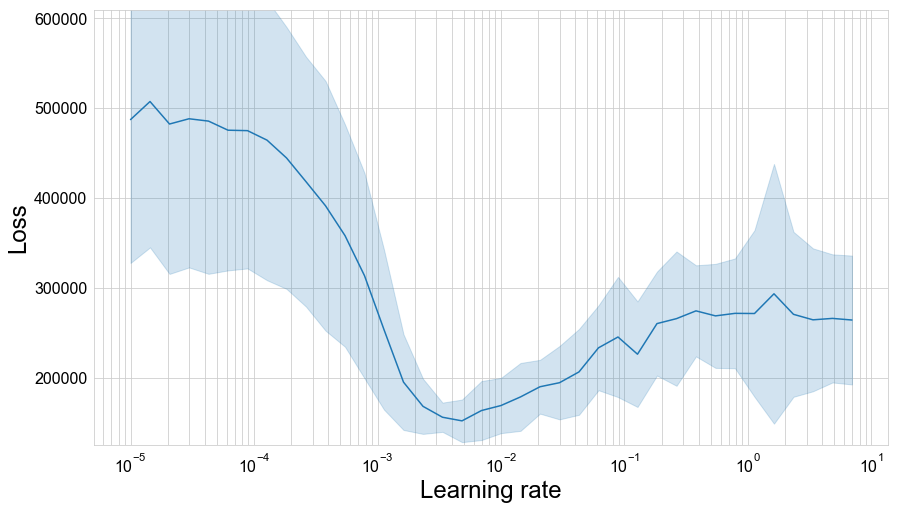

In [34]:
from lumin.optimisation.hyper_param import fold_lr_find
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-5,1e1])

Looks like somewhere around 1e-3 should be good.

The training function takes several sets of callbacks, ways to alter the model's training schedule, to report more specialised results, to affect the earlystopping, and to keep track of model weights.

For this example we'll use [Stochastic Weight Averaging](https://arxiv.org/abs/1803.05407) to train an average of models in a single training. Note that unlike the paper implementation, which required specifying a start point for model averaging, here we run multiple average models, separated by several epochs, and regularly compare their performances to get the best average.

We'll also add an evaluation metric to calculate the (bootstrapped) standard deviation of the difference between the predicted Higgs masses and the true value.

In [35]:
from lumin.data_processing.hep_proc import calc_pair_mass
def reg_proxy_func(df):
    df['pred'] = calc_pair_mass(df, (1.77682, 1.77682),
                                {targ[targ.find('_t')+3:]: f'pred_{i}' for i, targ in enumerate(targ_feats)})
    df['gen_target'] = 125

In [36]:
from lumin.nn.callbacks.model_callbacks import OldSWA
from lumin.nn.metrics.reg_eval import RegAsProxyPull
from functools import partial

n_models = 1
patience = 50
max_epochs = 100

model_builder.set_lr(1e-3)
callback_partials = [partial(OldSWA, start_epoch=5, renewal_period=5, verbose=0)]
eval_metrics = {'Pull': RegAsProxyPull(proxy_func=reg_proxy_func, return_mean=False, use_pull=False)}

`fold_train_ensemble` performs training of (an ensemble of) models produced by the `ModelBuilder` using data provided by a `FoldYielder`. Model training  runs for upto `max_epochs` number of epochs, or until `patience` number of sub-epochs (or cycles) have elapsed with out an improvment of the validation loss. The model is then saved to `saveloc` to be loaded later. The function returns results of the training and model perfomance on validation fold. If an `AbsCyclicCallback` is used, then snapshots of the model weights are automatically saved after each cycle to allow for [Snapshot Ensembling](https://arxiv.org/abs/1704.00109) or [Fast Geometric Ensembling](https://arxiv.org/abs/1802.10026).

Training model 1 / 1, Val ID = 0


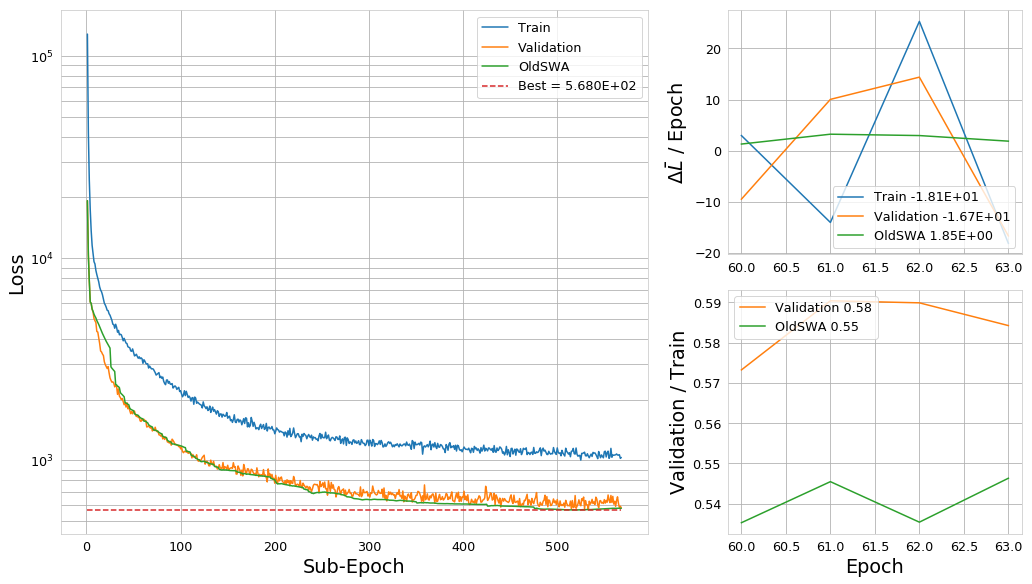

Early stopping after 568 sub-epochs
Scores are: {'loss': 568.0337524414062, 'Pull': 13.173163412119914}
Fold took 111.948s


______________________________________
Training finished
Cross-validation took 112.415s 


<Figure size 1024x576 with 0 Axes>

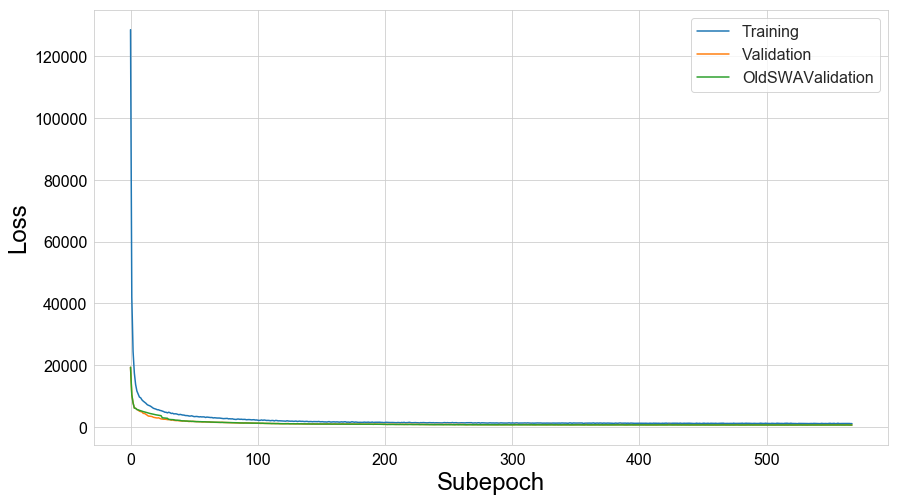

Mean loss = 568.0337524414062±0.0
Mean Pull = 13.173163412119914±0.0
______________________________________



In [37]:
from lumin.nn.training.fold_train import fold_train_ensemble
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)

## Model loading
The model we just trained is located in the `saveloc` argument provided to `fold_train_ensemble` (by default = `./train_weights`).

In [38]:
model = OldModel.from_save('train_weights/train_0.h5', model_builder)

The default location is likely to be overwritten, so we can save it to a more permanent location.

In [39]:
name = 'weights/Multi_Target_Regression'
with open(f'{name}_builder.pkl', 'wb') as fout: pickle.dump(model_builder, fout)
model.save(f'{name}.h5')

## Validation
Now we can test how well our ensemble performs on our validation set.

In [40]:
val_fy = FoldYielder(h5py.File(PATH/'val.hdf5', "r+"), ignore_feats=ignore_feats, input_pipe=input_pipe)

In [41]:
model.predict(val_fy)

Mean time per event = 2e-06±1e-07


In [42]:
df = val_fy.get_df(inc_inputs=True, deprocess=True)

12281 datapoints loaded


In [43]:
reg_proxy_func(df)

In [44]:
df.head()

,t_0_mass,b_0_mass,b_1_mass,h_tt_mass,h_bb_mass,diH_mass,hT,sT,centrality,eVis,...,gen_target_4,gen_target_5,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred,gen_target
0,3.863049,34.578518,44.748295,217.826050,190.851318,983.694153,467.174011,849.382202,0.810293,753.263733,...,318.726074,318.031738,36.305389,0.784592,27.077805,235.771790,282.473145,289.454773,95.985334,125
1,2.689086,6.746904,15.731952,119.019447,128.488556,375.777344,285.306396,374.317627,0.601425,541.694885,...,46.590916,51.497105,110.845634,-0.085526,55.997818,-5.676758,54.117828,64.320007,122.486023,125
2,14.707780,7.869730,8.966624,166.957291,98.596733,396.738007,570.989807,763.836975,0.377769,1643.567505,...,104.719688,55.929569,171.110184,0.298843,143.801086,118.334473,86.454269,47.152344,121.339627,125
3,3.558369,20.877790,9.415410,134.143707,140.076538,460.090057,469.084747,627.770935,0.481838,1063.563232,...,141.350555,116.977959,40.721966,0.194061,8.555073,-0.458374,149.917374,123.542664,118.550224,125
4,1.218421,29.130152,16.463116,99.656891,138.872040,592.894409,1038.730713,1327.328247,0.790282,1372.937134,...,134.942154,156.969406,74.999153,0.419861,11.367714,198.872192,167.111267,173.107788,116.070178,125


We'll compute the delta and pulls of the di-Higgs mass and then use bootstrapping to get reliable KDEs and moments for the distributions

In [45]:
df['reco_delta'] = df['h_tt_mass']-df['gen_target']
df['pred_delta'] = df['pred']-df['gen_target']
df['reco_pull'] = df['reco_delta']/df['gen_target']
df['pred_pull'] = df['pred_delta']/df['gen_target']

In [46]:
from lumin.utils.statistics import bootstrap_stats
from lumin.utils.multiprocessing import mp_run
x = np.linspace(0, 300, 500)
x_delta = np.linspace(-50, 200, 500)
x_pull = np.linspace(-1, 1, 500)

bs_stats = mp_run([{'data':df.h_tt_mass, 'name':'reco', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred, 'name':'pred', 'x':x, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_delta, 'name':'reco_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.reco_pull, 'name':'reco_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_delta, 'name':'pred_delta', 'x':x_delta, 'kde':1, 'mean':1, 'std':1},
                   {'data':df.pred_pull, 'name':'pred_pull', 'x':x_pull, 'kde':1, 'mean':1, 'std':1}], bootstrap_stats)

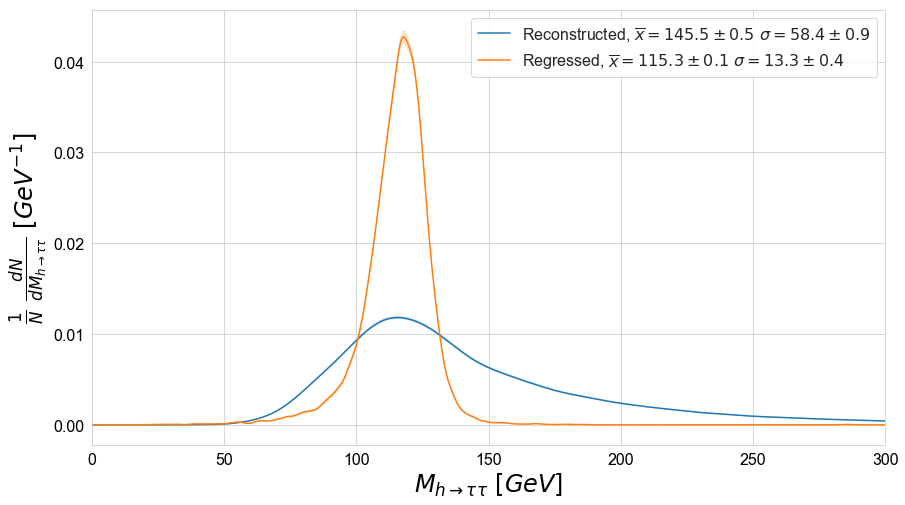

In [47]:
from lumin.plotting.data_viewing import plot_kdes_from_bs
plot_kdes_from_bs(x, {s:bs_stats[s] for s in bs_stats if 'reco' in s or 'gen' in s or 'pred' in s},
                  {'reco': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$M_{h\rightarrow\tau\tau}$', units='GeV')

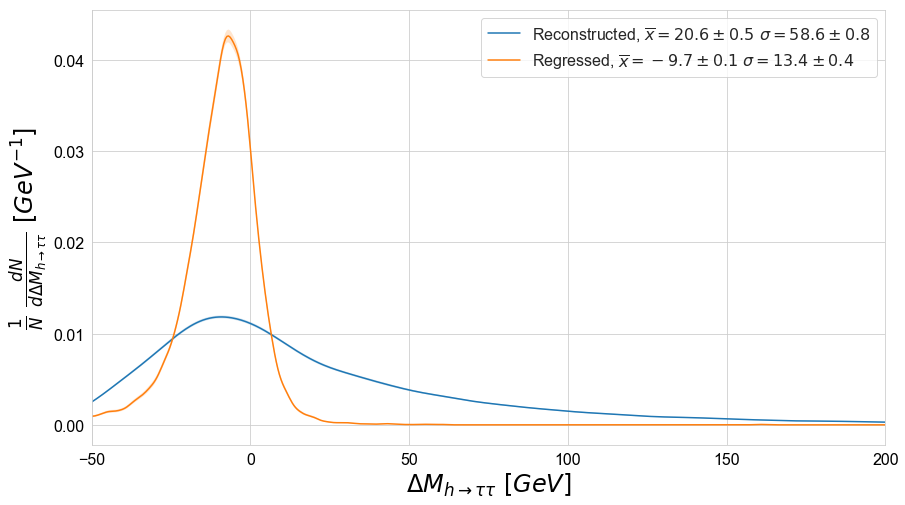

In [48]:
plot_kdes_from_bs(x_delta, {s:bs_stats[s] for s in bs_stats if 'delta' in s},
                  {'reco_delta': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_delta': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{h\rightarrow\tau\tau}$', units='GeV')

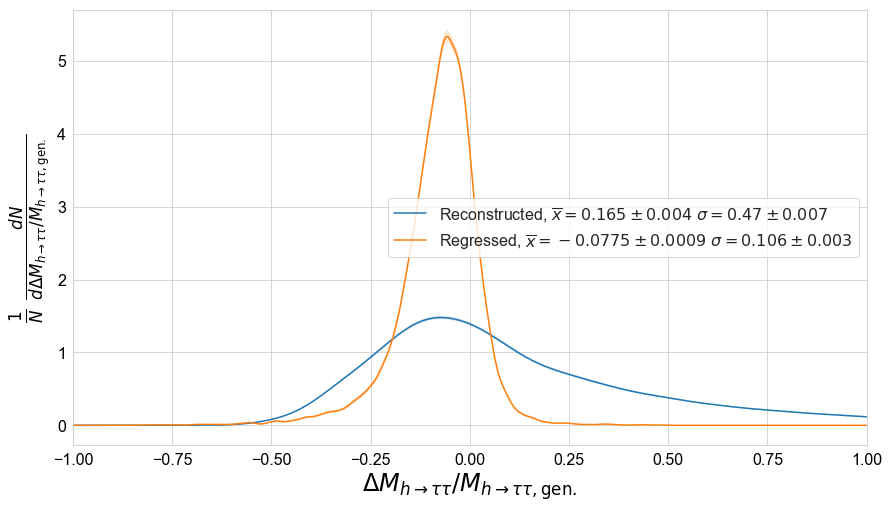

In [49]:
plot_kdes_from_bs(x_pull, {s:bs_stats[s] for s in bs_stats if 'pull' in s},
                  {'reco_pull': {'condition': 'Reconstructed', 'ci': 'sd'},
                   'pred_pull': {'condition': 'Regressed', 'ci': 'sd'}},
                  feat=r'$\Delta M_{h\rightarrow\tau\tau}/M_{h\rightarrow\tau\tau, \mathrm{gen.}}$')

## Interpretation 
So, we now have a model which improves our estimate of the $h_{\tau\tau}$ mass by about 80%. One might very well be interested in what information the ensemble is using to get such an improvement.

### Feature importance
In the same way as we used permutation importance to rank features with random forests, we can use the same technique to rank features with our ensemble.

Top ten most important features:
    Feature  Importance  Uncertainty
0   t_1_pz   13.109489     1.393295
1  h_tt_pz    4.226900     0.412618
2   t_1_px    3.775046     0.275214
3   t_0_pz    3.584580     0.417406
4   t_1_py    2.597149     0.275781
5   mPT_py    1.769090     0.222604
6   t_0_px    1.605468     0.176232
7   mPT_pT    0.923946     0.099161
8   mPT_px    0.875732     0.123643
9  h_tt_py    0.717098     0.075739


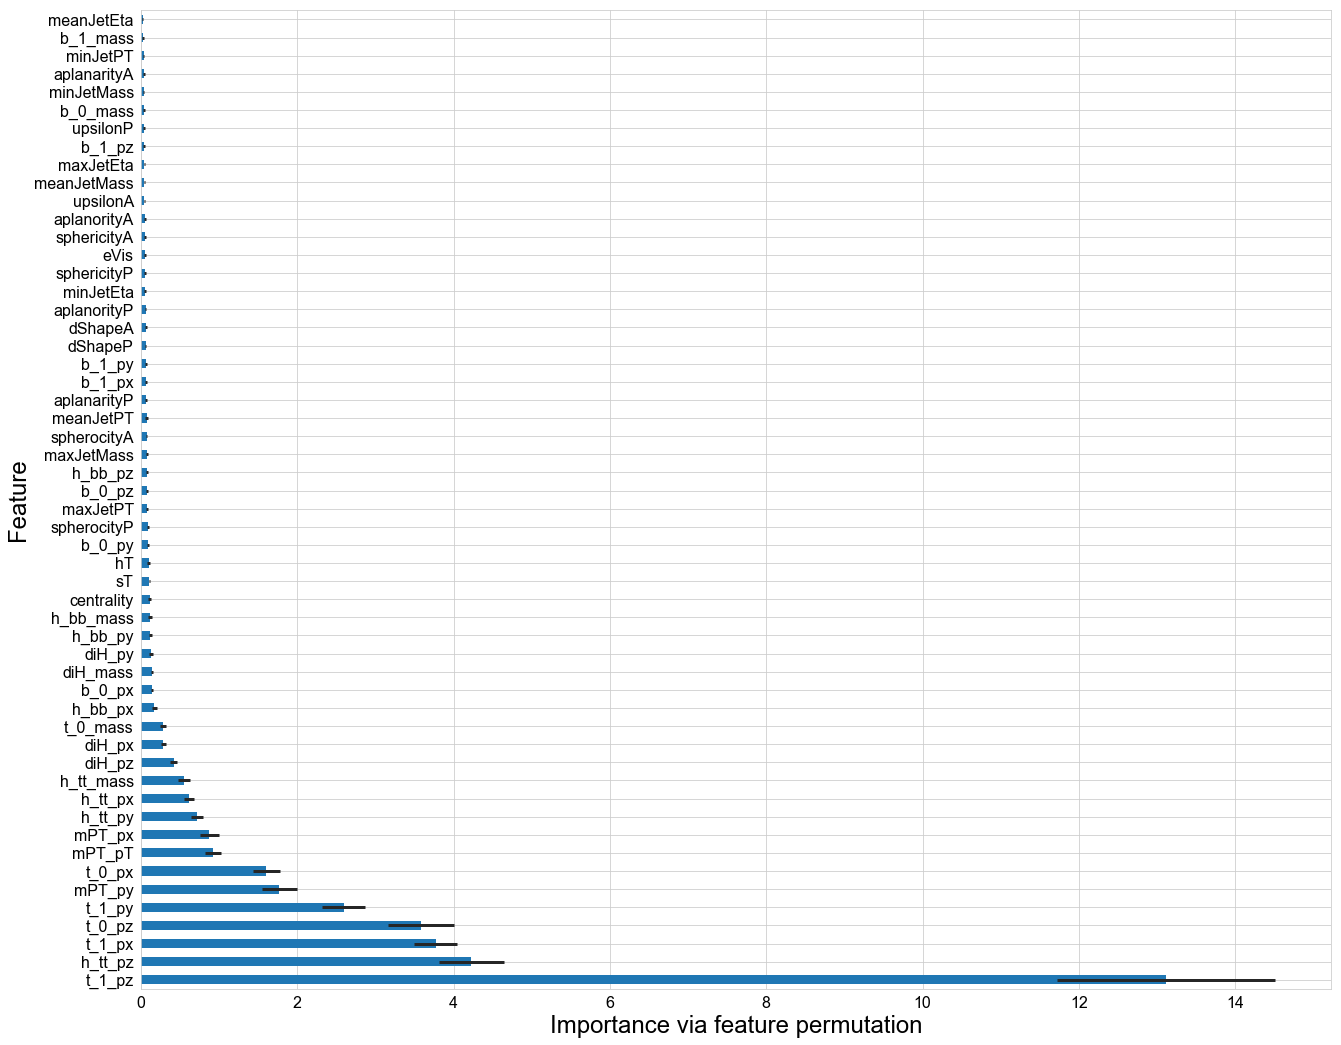

In [50]:
_ = model.get_feat_importance(train_fy)

As expected, the reconstructed momenta are providing a basis for the regression, with other features allowing improve calibration. The seemingly large importance of the `t_1_pz` feature can be explained by the fact that the feature importance in evaluated by the MSE, which is linked to the scale of the features; the $p_z$ spans a larger scale than the transverse momenta, so a similar change results in a larger increase in MSE.

Since we're really using the momenta regression as a proxy to the mass, we can instead pass an `eval_metric` to get the effect of each feature on the pull of the mass.

Top ten most important features:
      Feature  Importance  Uncertainty
0     t_1_pz    2.053894     0.117507
1     t_0_pz    1.396528     0.065565
2     t_1_px    0.891661     0.063244
3     t_0_px    0.757338     0.038808
4    h_tt_pz    0.552205     0.061270
5     t_1_py    0.346134     0.031170
6     mPT_pT    0.325814     0.026849
7     mPT_py    0.092022     0.013113
8  h_tt_mass    0.089935     0.016781
9     mPT_px    0.064303     0.012119


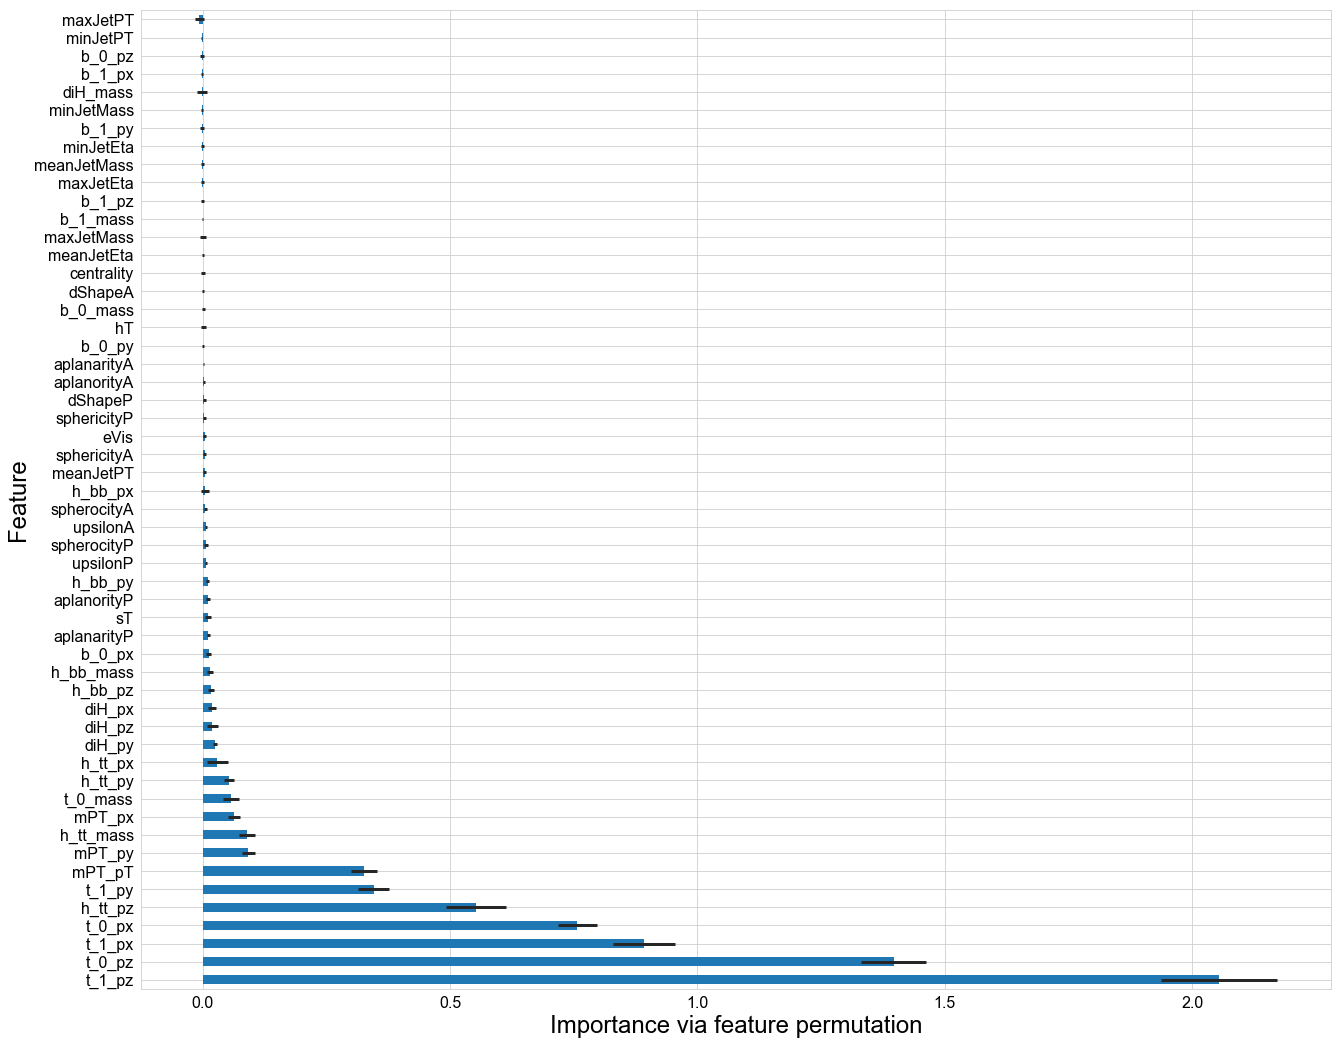

In [51]:
_ = model.get_feat_importance(train_fy,eval_metric=RegAsProxyPull(proxy_func=reg_proxy_func,
                                                                  return_mean=False, use_pull=False))

So, `t_1_pz` is still a very important feature, however other features have now become more important than they were.

### Partial dependence
Another way to use our model rather than simply making decisions based the data, is to use to to better understand the data itself. In business, one could predict the influence that any handles that are available could have on some outcome. In high-energy physics, our available handles are quite limited; the collider is already built and difficult to modify. However it could be useful to have some information available to inform future decisions, or know where to concentrate algorithm development.

An example of how we can additionally use our model is plot the partial dependencies of the prediction on (pairs of) features. Basically this means taking a feature and working out how the prediction changes if everything else is kept the same and only the given feature is altered. `plot_1d_partial_dependence` and `plot_2d_partial_dependence` are wrapper functions for PDPbox, to handle the fact that our model expects pre-processed inputs, but we'd like to see the original data.

The PDPbox methods, however, only works for models with a single output, so we'll add an endcap to the model, to reduce the predictions to binary. Endcaps take a model as a parameter and then pass inputs to it, and then apply a function to the model outputs.

In [52]:
from lumin.nn.models.blocks.endcap import AbsEndcap
from lumin.utils.misc import to_device
import torch
import torch.nn as nn
from torch import Tensor
from typing import Tuple
    
class PairMom2Mass(AbsEndcap):
    def __init__(self, model:nn.Module, masses:Tuple[float,float]):
        super().__init__(model)
        self.masses = to_device(Tensor(masses))**2
    
    def func(self, x:Tensor):
        e_0 = torch.sqrt(self.masses[0]+(x[:,0]**2)+(x[:,1]**2)+(x[:,2]**2))
        e_1 = torch.sqrt(self.masses[1]+(x[:,3]**2)+(x[:,4]**2)+(x[:,5]**2))
        p_x2 = (x[:,0]+x[:,3])**2
        p_y2 = (x[:,1]+x[:,4])**2
        p_z2 = (x[:,2]+x[:,5])**2
        return torch.sqrt(((e_0+e_1)**2)-p_x2-p_y2-p_z2)

In [53]:
data = val_fy.get_fold(0)['inputs']

In [54]:
df = pd.DataFrame(model.predict(data), columns=[f'pred_{x}' for x in range(6)])
reg_proxy_func(df)
df.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred,gen_target
0,36.305389,0.784592,27.077805,235.771790,282.473145,289.454773,95.985191,125
1,110.845634,-0.085526,55.997818,-5.676758,54.117828,64.320007,122.486023,125
2,171.110184,0.298843,143.801086,118.334473,86.454269,47.152344,121.339592,125
3,40.721966,0.194061,8.555073,-0.458374,149.917374,123.542664,118.550209,125
4,74.999153,0.419861,11.367714,198.872192,167.111267,173.107788,116.070221,125


In [55]:
endcap = PairMom2Mass(model, (1.77682, 1.77682))
df['pred_endcap'] = endcap.predict(data)

In [56]:
df.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred,gen_target,pred_endcap
0,36.305389,0.784592,27.077805,235.771790,282.473145,289.454773,95.985191,125,95.985069
1,110.845634,-0.085526,55.997818,-5.676758,54.117828,64.320007,122.486023,125,122.486023
2,171.110184,0.298843,143.801086,118.334473,86.454269,47.152344,121.339592,125,121.339592
3,40.721966,0.194061,8.555073,-0.458374,149.917374,123.542664,118.550209,125,118.550209
4,74.999153,0.419861,11.367714,198.872192,167.111267,173.107788,116.070221,125,116.070206


Seems to be working

In [57]:
from lumin.plotting.interpretation import plot_1d_partial_dependence, plot_2d_partial_dependence

In [58]:
train_fy.add_input_pipe_from_file('data/input_pipe.pkl')
train_df = train_fy.get_df(inc_inputs=True, inc_ignore=True)

49124 datapoints loaded


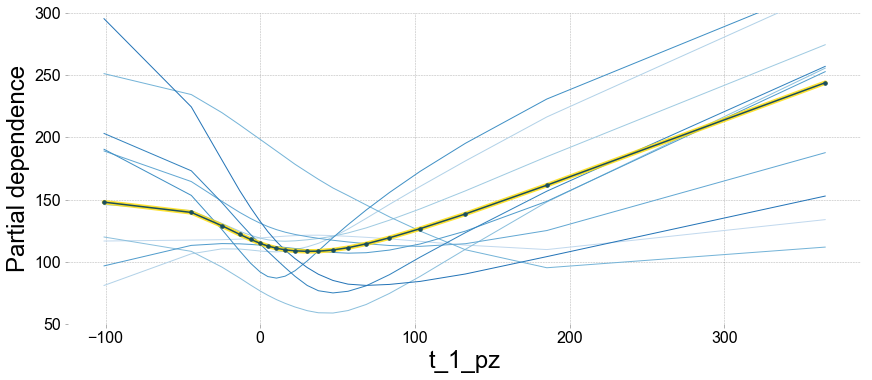

In [59]:
plot_1d_partial_dependence(endcap, df=train_df, feat='t_1_pz', train_feats=train_feats,
                           input_pipe=input_pipe, ignore_feats=train_fy.get_ignore(), sample_sz=2000,
                           y_lim=[50,300], pdp_isolate_kargs={'percentile_range':(1,99)})

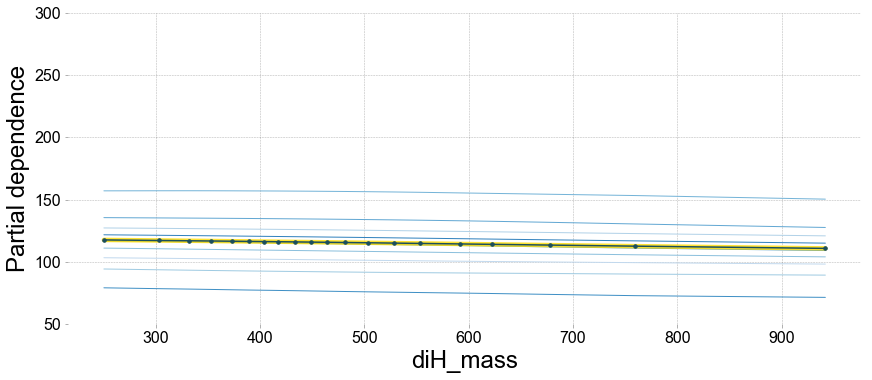

In [60]:
plot_1d_partial_dependence(endcap, df=train_df, feat='diH_mass', train_feats=train_feats,
                           input_pipe=input_pipe, ignore_feats=train_fy.get_ignore(), sample_sz=2000,
                           y_lim=[50,300], pdp_isolate_kargs={'percentile_range':(1,99)})

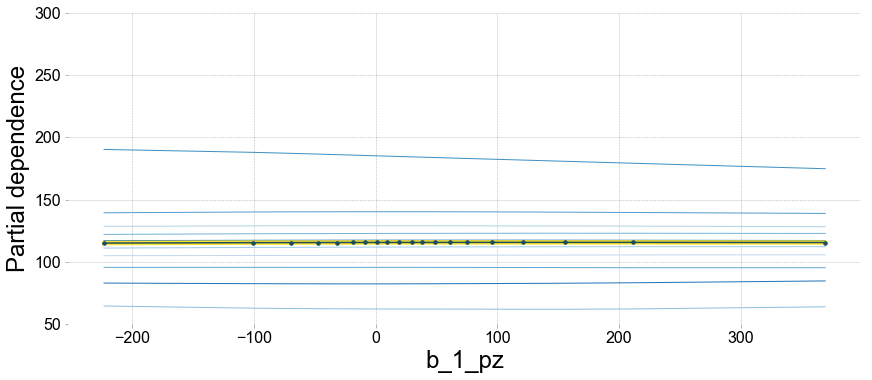

In [61]:
plot_1d_partial_dependence(endcap, df=train_df, feat='b_1_pz', train_feats=train_feats,
                           input_pipe=input_pipe, ignore_feats=train_fy.get_ignore(), sample_sz=2000,
                           y_lim=[50,300], pdp_isolate_kargs={'percentile_range':(1,99)})

As expected, the mass is most sensitive to the low-level tau features, unrelated features show flat dependence centred at the Higgs mass.

We can also plot partial interactions between pairs of features:

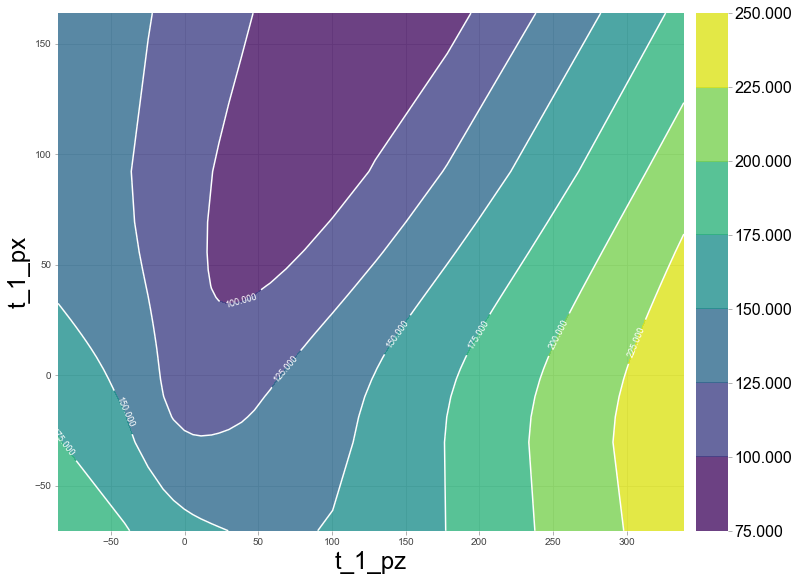

In [62]:
plot_2d_partial_dependence(endcap, df=train_df, feats=['t_1_pz','t_1_px'], train_feats=train_feats,
                           input_pipe=input_pipe, sample_sz=2000, ignore_feats=train_fy.get_ignore(),
                           pdp_interact_kargs={'percentile_ranges':[(1,99),(1,99)]})